In [3]:
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
# Makes utils module visible
# Note - this is probably bad practice, but will work with this at the moment
import sys
sys.path.append('../')

In [5]:
import pandas as pd
import numpy as np

from utils.utils import *

Perform analysis on the processed das data

In [6]:
# Import modules
import seaborn as sns
from scipy import signal
import matplotlib.pyplot as plt
import pyoma2 as oma

# ======== PRE-PROCESSING =====================================================
# To open a .txt file create a variable containing the path to the file
# _file = "./test.txt" # Path to the txt file

# # open the file with pandas and create a dataframe
# # N.B. whatchout for header, separator and remove time column if present
# data = pd.read_csv(_file, header=0, sep="\t", index_col=False) 
# data = data.to_numpy()

# to retrieve the example data 
# data, (fex, FI_ex, xi_ex) = oma.Exdata()

In [7]:
# sampling rate = 100 Hz
fs = 100

In [18]:
# load in data
das_dir = r'F:\enel-data\short-exp-march-2024\das\cut-data\brake'
input_file_name = 'brake-bc5_filtered'

strain,_,_ = load_preprocessed_das_data(directory_to_file=das_dir,
                                                         input_file_name=input_file_name)

In [19]:
bot_name = 'bot_a'
mid_name = 'mid_a'
top_name = 'top_a'


total_strain = np.vstack([strain[bot_name].T, strain[mid_name].T, strain[top_name].T]) /10430.378350470453

In [20]:
print(np.shape(total_strain))

(74, 70300)


In [24]:
%matplotlib inline


In [21]:
from pyoma2.algorithm import FDD_algo,FSDD_algo,SSIcov_algo
from pyoma2.OMA import MultiSetup_PoSER, SingleSetup

In [22]:
# Run FDD

test_1 = SingleSetup(data=total_strain.T, 
                    fs=fs)

In [23]:
fdd = FDD_algo(name='FDD')
fsdd = FSDD_algo(name="FSDD", nxseg=2048, method_SD="per", pov=0.5)


In [24]:
# Overwrite/update run parameters for an algorithm
fdd.run_params = FDD_algo.RunParamCls(nxseg=512, method_SD="cor")

In [25]:
# Add algorithms to the single setup class
test_1.add_algorithms(fdd)
test_1.add_algorithms(fsdd)

In [26]:
# Run all or run by name
test_1.run_by_name("FSDD")
test_1.run_by_name("FDD")
# test_1.run_all()

2024-05-16 10:02:21,403 - pyoma2.OMA - INFO - Running FSDD... (OMA:154)
2024-05-16 10:02:35,645 - pyoma2.OMA - INFO - Running FDD... (OMA:154)


In [27]:
fsdd_res = dict(fsdd.result)
fdd_res = dict(fdd.result)

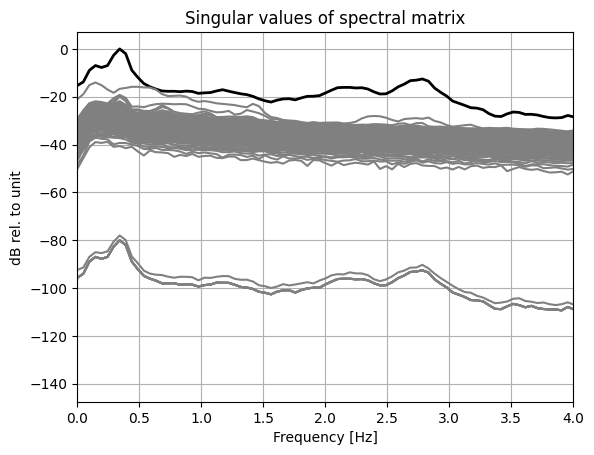

In [28]:
# plot Singular values of PSD
fig3, ax3 = fsdd.plot_CMIF(freqlim=(0,4))

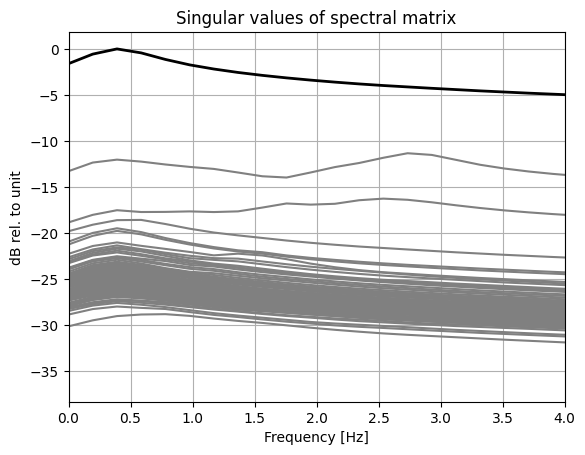

In [29]:
fig3, ax3 = fdd.plot_CMIF(freqlim=(0,4))

In [30]:
ssicov = SSIcov_algo(name="SSIcov", br=50, ordmax=80)

test_1.add_algorithms(ssicov)

In [31]:
test_1.run_by_name("SSIcov")

2024-05-16 10:03:00,579 - pyoma2.OMA - INFO - Running SSIcov... (OMA:154)
100%|██████████| 101/101 [00:00<00:00, 109.79it/s]
2024-05-16 10:03:23,331 - pyoma2.functions.SSI_funct - INFO - SSI for increasing model order... (SSI_funct:274)
100%|██████████| 81/81 [00:00<00:00, 1737.43it/s]


In [32]:
# save dict of results
ssi_res = ssicov.result.model_dump()

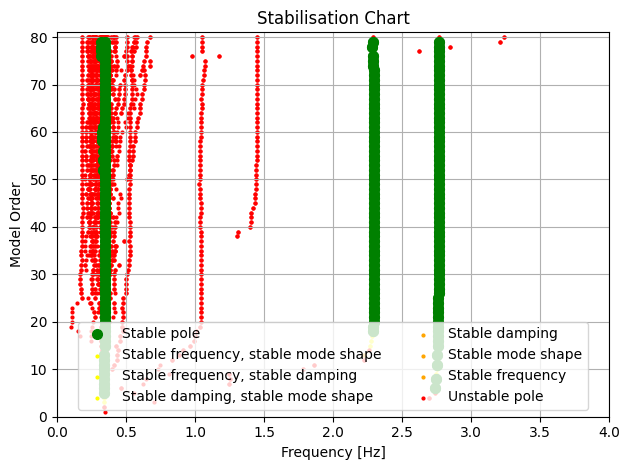

In [33]:
# plot Stabilisation chart for SSI
fig4, ax4 = ssicov.plot_STDiag(freqlim=(0,4), hide_poles=False)

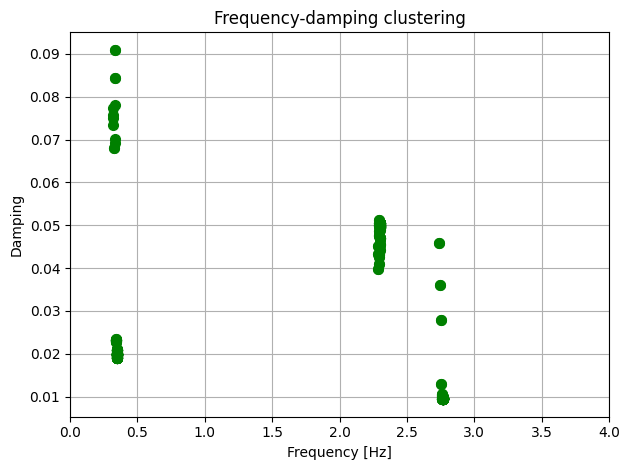

In [34]:
# plot frequecy-damping clusters for SSI
fig5, ax5 = ssicov.plot_cluster(freqlim=(0,4))

In [35]:
# Select modes to extract from plots
# test_1.MPE_fromPlot("SSIcov", freqlim=(0,4)) # Does this function work?

test_1.MPE("SSIcov", sel_freq=[.35, 1.5, 2.35,2.75], order=40)

2024-05-16 10:04:56,937 - pyoma2.OMA - INFO - Getting MPE modal parameters from SSIcov (OMA:180)
2024-05-16 10:04:56,938 - pyoma2.functions.SSI_funct - INFO - Extracting SSI modal parameters (SSI_funct:659)
  0%|          | 0/4 [00:00<?, ?it/s]2024-05-16 10:04:56,940 - pyoma2.functions.SSI_funct - WARNING - Could not find any values (SSI_funct:732)
2024-05-16 10:04:56,940 - pyoma2.functions.SSI_funct - WARNING - Could not find any values (SSI_funct:732)
100%|██████████| 4/4 [00:00<00:00, 1957.67it/s]


In [36]:
# test_1.MPE("FSDD", sel_freq=[.3, 1.5, 2.35,2.75], MAClim=0.95)
test_1.MPE("FDD", sel_freq=[.35, 1.5, 2.35,2.75],DF=0.1)


2024-05-16 10:05:03,979 - pyoma2.OMA - INFO - Getting MPE modal parameters from FDD (OMA:180)
2024-05-16 10:05:03,980 - pyoma2.functions.FDD_funct - INFO - Extracting FDD modal parameters (FDD_funct:284)
100%|██████████| 4/4 [00:00<?, ?it/s]


In [37]:
# update dict of results
# fsdd_res = dict(fsdd.result)
fdd_res = dict(fdd.result)

In [45]:
# print(fdd_res['Phi'])
print(fdd_res['Fn'])
print(np.shape(fdd_res['Phi'][1]))
print(fdd_res['Phi'][:,1])
print(fdd_res['Phi'][2])

[0.1953125 1.3671875 2.34375   2.734375 ]
(4,)
[0.00551918+2.00502978e-04j 0.04804512+2.12696500e-04j
 0.42617533+7.13066864e-04j 0.7295965 +1.55567675e-03j
 0.81948598+2.23995004e-03j 0.84635263+1.72773683e-03j
 0.83855613+1.83947713e-03j 0.85369274+1.91167451e-03j
 0.84361394+6.18664176e-04j 0.78945312+1.78040526e-03j
 0.84259462+2.11662697e-03j 0.90383426+1.52505151e-03j
 0.8912866 +1.38429498e-03j 0.8428276 +1.65893071e-03j
 0.82429619+1.82287652e-03j 0.85210269+1.12897306e-03j
 0.83715638+8.41603749e-04j 0.88600372+1.10372416e-03j
 0.83185822+7.12599998e-04j 0.49371126+7.42026669e-04j
 0.12115925+5.30088492e-04j 0.12983832+3.26185996e-04j
 0.60034618+4.21338321e-04j 0.89047649+8.08462733e-04j
 0.89941216+2.15454294e-05j 0.88483928+4.52246168e-04j
 0.87882107-5.69867491e-06j 0.87203796+7.22126660e-04j
 0.89429893+3.59127316e-04j 0.91878427+8.32149397e-04j
 0.99224552+2.19426480e-04j 1.        -0.00000000e+00j
 0.98665265-5.96190616e-04j 0.99208177-1.42789822e-04j
 0.97153908+1.1481

In [46]:
import numpy as np

def sign_finder(in_angle):
    """ Helper function to determine the sign based on the phase angle. """
    if 0 <= in_angle < np.pi / 2:
        return 1
    elif np.pi / 2 <= in_angle <= np.pi:
        return -1
    elif -np.pi <= in_angle < -np.pi / 2:
        return -1
    elif -np.pi / 2 <= in_angle < 0:
        return 1

def rotation_max_cor(in_complex):
    """ Rotates the complex data to align with the maximum correlation line. """
    x = np.real(in_complex)
    y = np.imag(in_complex)
    p = np.polyfit(x, y, 1)  # Fit a first order line to the data
    theta = -np.arctan(p[0])  # Angle of maximum correlation line
    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta),  np.cos(theta)]])  # Rotation matrix
    
    out = np.zeros_like(in_complex, dtype=complex)
    for i in range(len(in_complex)):
        n = rot @ np.array([x[i], y[i]])
        out[i] = n[0] + 1j * n[1]
    return out

def complex_mode_to_real_mode(complex_data):
    """ Converts a complex mode shape to a real-valued one. """
    # Rotate the complex mode shapes
    complex_data = rotation_max_cor(complex_data)

    # 1: Find the modulus of the mode shape
    modulus = np.abs(complex_data)
    
    # 2: Normalize the modulus
    modulus /= np.max(modulus)
    
    # 3: Find the phase of each component
    phase = np.angle(complex_data)
    
    # 4: Find the sign of each component
    sign = np.zeros_like(modulus)
    for i in range(len(modulus)):
        if modulus[i] != 0:
            sign[i] = sign_finder(phase[i])
        else:
            sign[i] = 0
    
    # 5: Compute the real-valued mode shape
    real = modulus * sign
    return real



In [53]:
# Example usage:
complex_data = np.array(fdd_res['Phi'][:,1])
real_mode_shape = complex_mode_to_real_mode(complex_data)
print(real_mode_shape)

[0.00552283 0.04804559 0.42617593 0.72959816 0.81948904 0.84635439
 0.83855814 0.85369488 0.84361416 0.78945512 0.84259728 0.90383555
 0.89128767 0.84282923 0.82429821 0.85210344 0.8371568  0.88600441
 0.83185853 0.49371182 0.12116041 0.12983872 0.60034633 0.89047685
 0.89941216 0.8848394  0.87882107 0.87203826 0.89429901 0.91878465
 0.99224554 1.         0.98665283 0.99208178 0.97153909 0.95795039
 0.97406845 0.96708619 0.93970683 0.94058241 0.93295816 0.95394914
 0.96641795 0.95701155 0.91850691 0.6661784  0.45373748 0.64607314
 0.88356429 0.90167    0.8818735  0.87320295 0.85390018 0.87854486
 0.86157118 0.81994084 0.7955371  0.7756659  0.74871858 0.72413325
 0.69447342 0.67992859 0.65640577 0.60369215 0.56062708 0.5290564
 0.48006566 0.42915026 0.41320985 0.37412701 0.33865366 0.29291495
 0.2259995  0.14384263]


In [ ]:
plt.plot(X = real_mode_shape,Y = height)

In [64]:
ssicov.result.Fn


array([1.49650998, 2.35264792])

In [1]:
fdd.result.Fn



NameError: name 'fdd' is not defined

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular values of spectral matrix'}, xlabel='Frequency [Hz]', ylabel='dB rel. to unit'>)

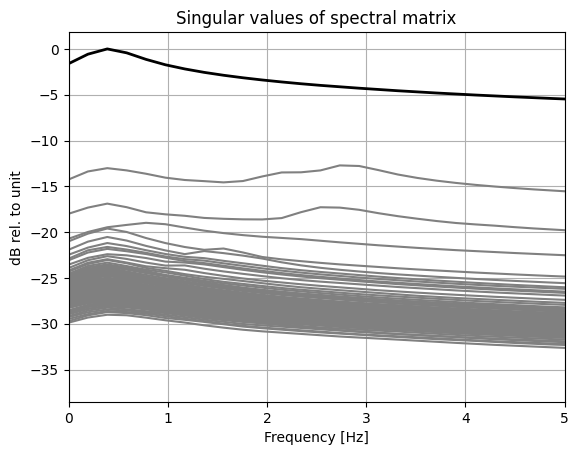

In [66]:
# plot Singular values of PSD
fdd.plot_CMIF(freqlim=(0,5))

2024-05-14 17:41:14,794 - pyoma2.functions.FDD_funct - INFO - Extracting FDD modal parameters (FDD_funct:284)
100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


In [103]:
fdd_1.plot_mode_g1()

TypeError: FDD_algo.plot_mode_g1() missing 2 required positional arguments: 'Geo1' and 'mode_numb'

2024-05-14 17:20:44,095 - pyoma2.functions.plot_funct - ERROR - index 74 is out of bounds for axis 1 with size 74 (plot_funct:917)
Traceback (most recent call last):
  File "c:\Users\jxu20\Anaconda3\envs\wind-env\Lib\site-packages\pyoma2\functions\plot_funct.py", line 901, in plt_data
    ax.plot(time, data[:, kk], c="k")
                  ~~~~^^^^^^^
IndexError: index 74 is out of bounds for axis 1 with size 74
c:\Users\jxu20\Anaconda3\envs\wind-env\Lib\site-packages\pyoma2\functions\plot_funct.py:939: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


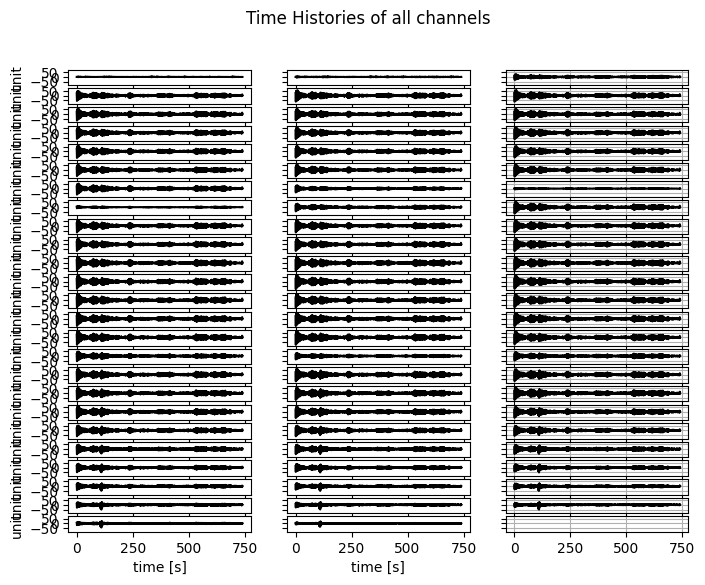

In [86]:
# Plot the Time Histories
fig1, ax1 = test_1.plot_data(nc=3)

In [87]:
fig1.set_size_inches(10,50)

In [91]:
# fig1

In [90]:
# ssicov_1 = SSIcov_algo(name='SSIcov1',method='cov_mm',br=50,ordmax=80)
# ssi_1.add_algorithms(ssicov_1)
# ssi_1.run_all()

In [27]:
FreQ = [0.3,.9,2.6,5]

In [28]:
Res_FDD = oma.FDDmodEX(FreQ, FDD[1])

In [35]:
print(Res_FDD['Frequencies'])
# Res_FDD['Mode Shapes']


[0.31 0.91 2.59 5.01]


In [36]:
# load in data
das_dir = r'F:\enel-data\short-exp-march-2024\das\cut-data\brake'
input_file_name = 'brake-bc5'

strain,_,_ = load_preprocessed_das_data(directory_to_file=das_dir,
                                                         input_file_name=input_file_name)

In [37]:
bot_name = 'bot_a'
mid_name = 'mid_b'
top_name = 'top_c'


total_strain = np.vstack([strain[bot_name].T, strain[mid_name].T, strain[top_name].T]) /10430.378350470453

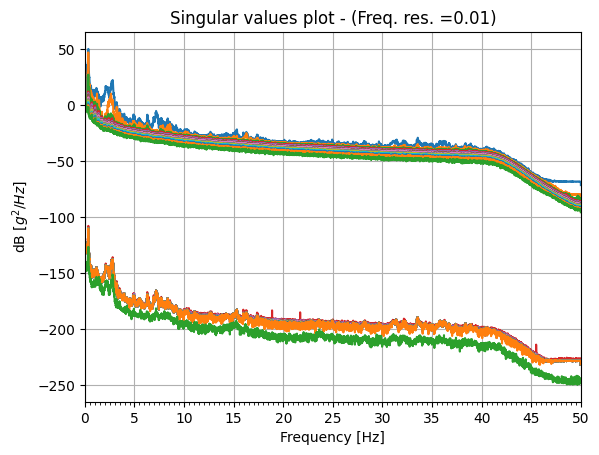

In [38]:
# Run FDD

FDD = oma.FDDsvp(total_strain.T,  fs)

In [40]:
FreQ = [0.3,.9,2.6,5]

In [41]:
Res_FDD = oma.FDDmodEX(FreQ, FDD[1])

In [42]:
print(Res_FDD['Frequencies'])
# Res_FDD['Mode Shapes']

[0.29 0.91 2.58 4.98]


In [44]:
# Run SSI
br = 15
SSIcov= oma.SSIcovStaDiag(total_strain.T, fs, br) # running SSI-cov
SSIdat = oma.SSIdatStaDiag(total_strain.T, fs, br, ordmax=60, lim=(0.01, 0.05, 0.02, 0.1))